# Stability of sentences

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



Equip models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

/home/sl/Code/Research/interpretation-experiment/analysis/linguistics.py:157: UserWarning: 'unordered_content' distance is always normalized, so we're ignoring normalized=False
  warn("'unordered_content' distance is always normalized, so "

  warn("'unordered_content' distance is always normalized, so "



## 2 Stability of sentences

First generate our data

In [5]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    root_length = len(root.content_words)
    order.append({'tree id': tree.id,
                  'root length': root_length})
    for sentence in tree.sentences.kept.all():
        if sentence.parent is None:
            rate = 0.0
            cumrate = 0.0
        else:
            rate = sentence.ordered_content_distance(sentence.parent)
            cumrate = sentence.cum_root_distance('ordered_content')
        length = len(sentence.content_words)
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': length,
                     'root length': root_length,
                     'length / len(root)': length / root_length,
                     'diff from root': \
                         root.ordered_content_distance(sentence, normalized=False) / \
                             root_length,
                     'depth': sentence.depth,
                     'rate': rate,
                     'cumrate': cumrate})
data = DataFrame(data)
data_m15 = data[data['root length'] < 15]
root_order = DataFrame(order).sort_values(['root length', 'tree id'])

### 2.1 Quick look at the interactions between transformation rate, length, depth

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



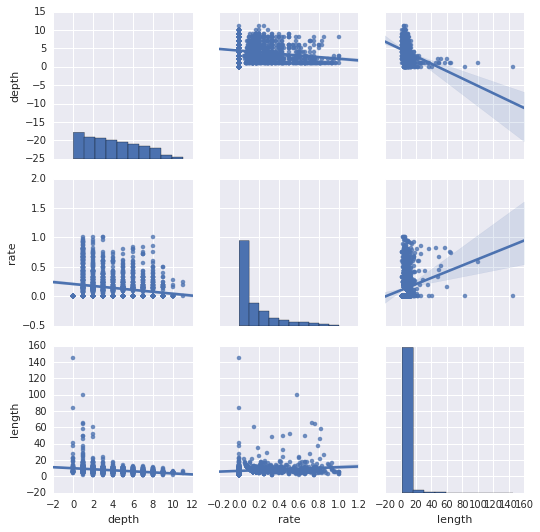

In [6]:
g = sb.pairplot(data=data, vars=['depth', 'rate', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/depth_tr_length_interactions.png', dpi=300)

Now restricting to sentences with less than 15 content words:

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



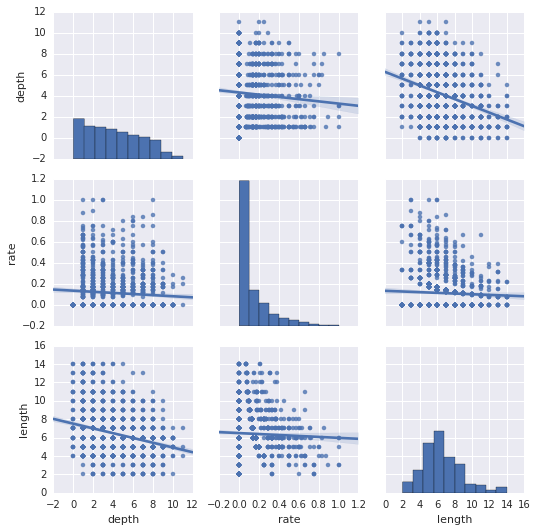

In [7]:
g = sb.pairplot(data=data_m15, vars=['depth', 'rate', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/depth_tr_length_interactions_m15.png', dpi=300)

### 2.2 At fixed sentence length, how does transformation rate depend on depth?

#### 2.2.1 Non-cumulative transformation rate

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



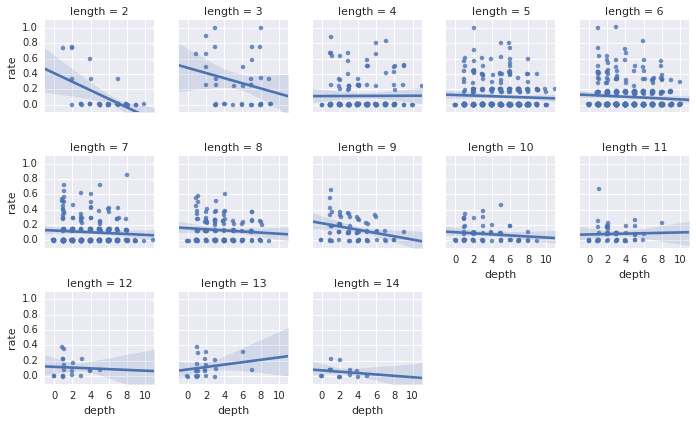

In [8]:
ordered_lengths_m15 = sorted(set(data_m15.length.values))
g = sb.lmplot(data=data_m15, x='depth', y='rate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths_m15,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/tr_depth_fixed-length.png', dpi=300)

#### 2.2.2 Cumulative transformation rate

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



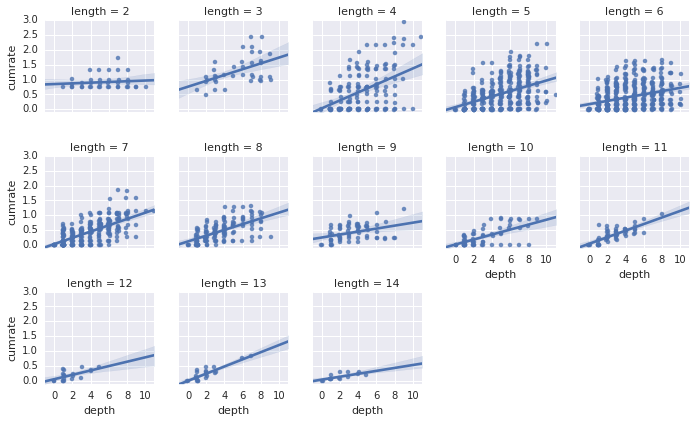

In [9]:
ordered_lengths_m15 = sorted(set(data_m15.length.values))
g = sb.lmplot(data=data_m15, x='depth', y='cumrate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths_m15,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 3))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/cumtr_depth_fixed-length.png', dpi=300)

### 2.3 How do trees behave with transformation rate ~ depth?

#### 2.3.1 Non-cumulative transformation rate

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



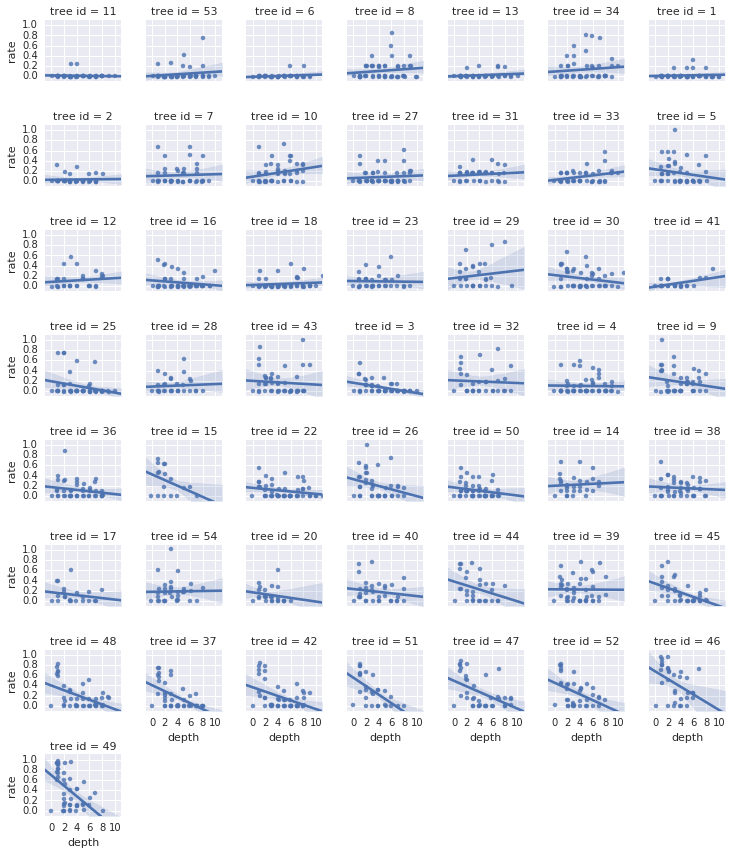

In [10]:
g = sb.lmplot(data=data,
              x='depth', y='rate',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/tr_depth.png', dpi=300)

#### 2.3.2 Cumulative transformation rate

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



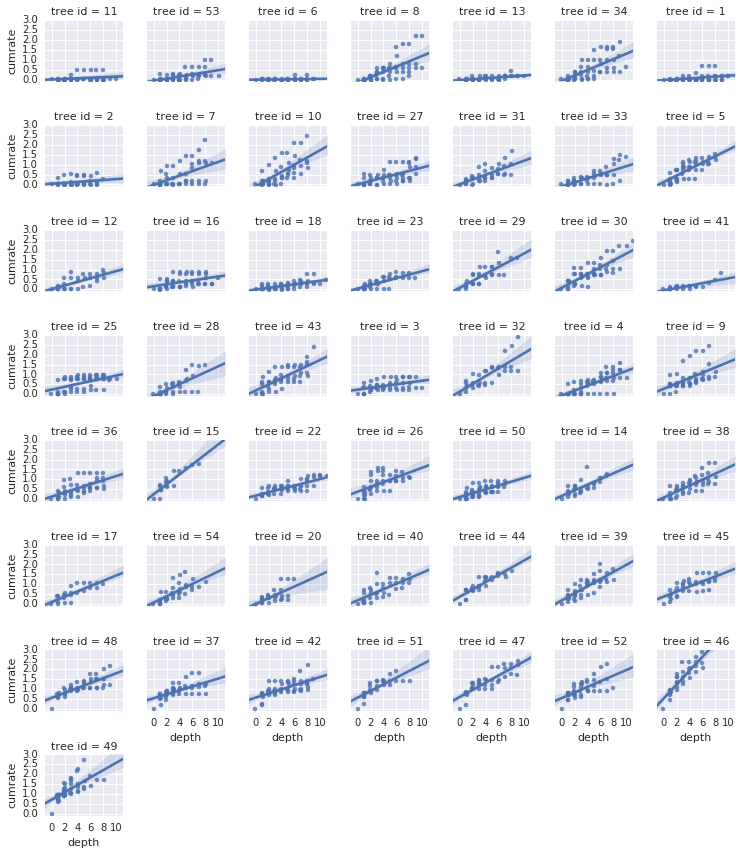

In [11]:
g = sb.lmplot(data=data,
              x='depth', y='cumrate',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 3))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/cumtr_depth.png', dpi=300)

### 2.4 How do trees behave with length ~ depth?

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



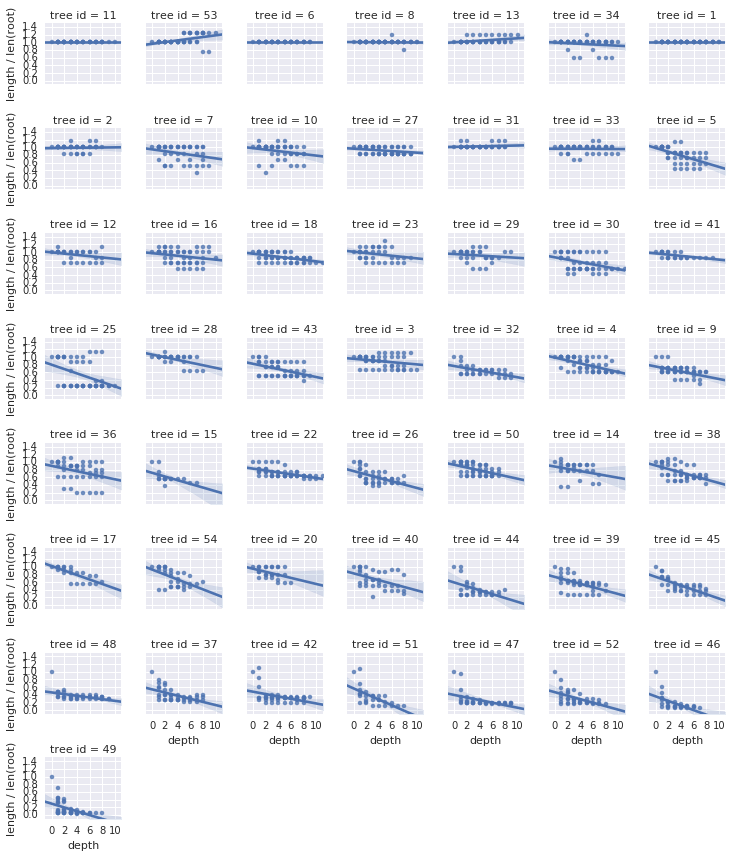

In [12]:
g = sb.lmplot(data=data,
              x='depth', y='length / len(root)',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 11), ylim=(-0.1, 1.5))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/length_depth.png', dpi=300)

In [13]:
print(Tree.objects.get(id=53).root.text)
print(Tree.objects.get(id=53).root.content_words)

He promised he'd be on time for the party tonight
['promis', 'time', 'parti', 'tonight']


In [14]:
[s.content_words for s in Tree.objects.get(id=53).sentences.kept.all()]

[['promis', 'would', 'time'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'night'],
 ['promis', 'll', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'night'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time'

In [15]:
print(Tree.objects.get(id=13).root.text)
print(Tree.objects.get(id=13).root.content_words)

Dinosaurs and humans walked the earth at the same time
['dinosaur', 'human', 'walk', 'earth', 'time']


In [16]:
[s.content_words for s in Tree.objects.get(id=13).sentences.kept.all()]

[['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaura', 'human', 'walk', 'earth', 'time'],
 ['dinosor', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['din

### 2.5 How do trees behave with difference from root ~ depth?

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



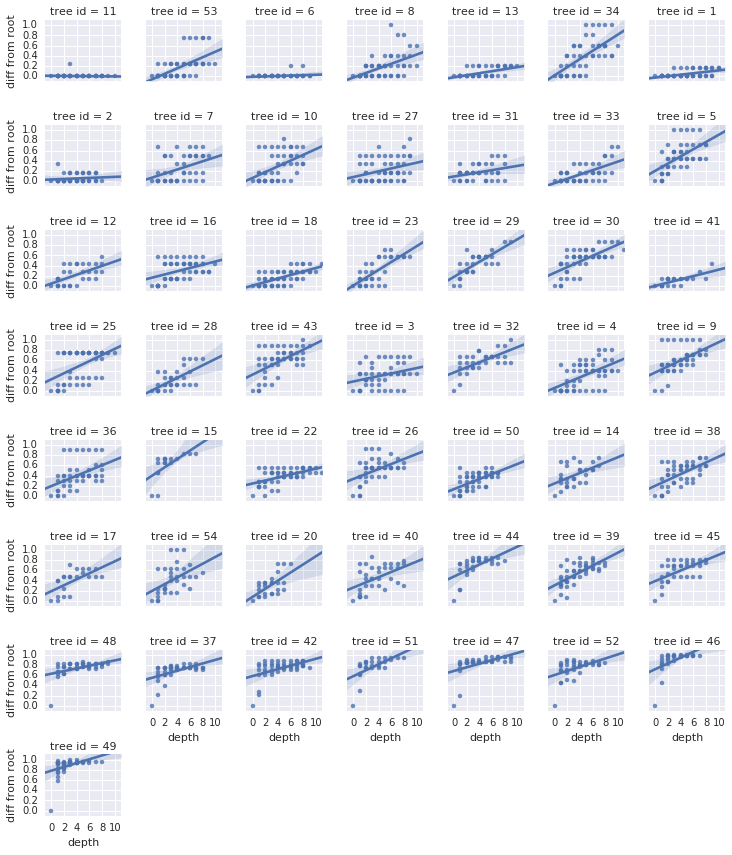

In [17]:
g = sb.lmplot(data=data,
              x='depth', y='diff from root',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/diffroot_depth.png', dpi=300)